In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('gdrive/MyDrive/boddam-masters-project')

Mounted at /content/gdrive


In [2]:
!sudo apt-get install openslide-tools
!sudo apt-get install python-openslide
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 5 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (73.0 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf

In [3]:
!pip install pyclesperanto-prototype

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 20.5 MB/s 
     |████████████████████████████████| 934 kB 61.1 MB/s 
     |████████████████████████████████| 1.4 MB 64.4 MB/s 
     |████████████████████████████████| 70 kB 9.7 MB/s 
  Created wheel for pytools: filename=pytools-2022.1.12-py2.py3-none-any.whl size=65033 sha256=33ac81aa271adf51a01e4074ecdc40d95159ac33daf187c51b9ba4163da3f877
  Stored in directory: /root/.cache/pip/wheels/37/5e/9e/76d7430e116b7cab0016fbabb26b896daae1946a3f7dea9915
  Created wheel for transforms3d: filename=transforms3d-0.4.1-py3-none-any.whl size=1376773 sha256=d665c0644f223d1512581f6bbec3213540d91cbcb478c86331cd0c3d82b9e59f
  Stored in directory: /root/.cache/pip/wheels/cc/da/f5/b05c90f16d37764a65c010013110b15eab345f9c310d1bc16f
Successfully built pytools transforms3d


In [4]:
from keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import pandas as pd
from PIL import Image
import glob
import numpy as np
from numpy import load, asarray, savez_compressed

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity

In [6]:
from openslide import ImageSlide, open_slide
import pyclesperanto_prototype as cle

In [7]:
import statistics


In [8]:
data_width, data_height = 250, 250
pixel_range = 256
train_data_dir = "data/train"
path_normal = "data/train/normal/normal1.svs"

path_tumor = "data/train/tumor/tumor1.svs"


In [9]:
images = []
classes = []

categories = {"normal", "tumor"}
for label in categories:
  imgdir = train_data_dir + "/" + label
  basename = '*.svs'
  filelist = glob.glob(os.path.join(imgdir, basename))
  for filename in filelist:
    im = open_slide(filename)
    imgwidth, imgheight = im.level_dimensions[0]

    height = int(imgheight/50)
    width = int(imgwidth/200)

    i = 0

    start_h = 0
    start_w = 0
    for m in range(start_h, imgheight, height):
      for n in range(start_w, imgwidth, width):

        if (m + height > imgheight) or (n + width > imgwidth) or i > 50:
          break
        
        print("reading region width ", n, " x ", m, " from " , filename)
        
        piece = im.read_region((n, m), 0, (width, height))
        img = Image.new("RGB", (width, height), pixel_range)
        img.paste(piece)
        img = img.resize(size = (data_width, data_height), resample=Image.LANCZOS)
        img = np.array(img)
        
        # the number below should be 240
        if (np.mean(img) < 240):
            images.append(img)
            classes.append(label)
            #plt.imshow(img)
            print("added image to array")
            i = i + 1
        else:
            print("white space")


dataframe = pd.DataFrame({"image": images, 
                          "label": classes})

print(dataframe.shape)

Streaming output truncated to the last 5000 lines.
white space
reading region width  20160  x  400  from  data/train/normal/normal1.svs
white space
reading region width  20370  x  400  from  data/train/normal/normal1.svs
white space
reading region width  20580  x  400  from  data/train/normal/normal1.svs
white space
reading region width  20790  x  400  from  data/train/normal/normal1.svs
white space
reading region width  21000  x  400  from  data/train/normal/normal1.svs
white space
reading region width  21210  x  400  from  data/train/normal/normal1.svs
white space
reading region width  21420  x  400  from  data/train/normal/normal1.svs
white space
reading region width  21630  x  400  from  data/train/normal/normal1.svs
white space
reading region width  21840  x  400  from  data/train/normal/normal1.svs
white space
reading region width  22050  x  400  from  data/train/normal/normal1.svs
white space
reading region width  22260  x  400  from  data/train/normal/normal1.svs
white space
re

In [10]:
print(len(images))
print(images[0].shape)
print(images[101].shape)

102
(250, 250, 3)
(250, 250, 3)


normal


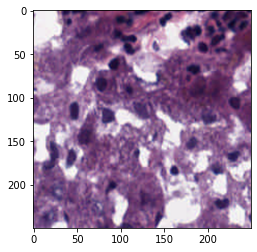

In [14]:
print("normal")
plt.imshow(images[23])

tumor


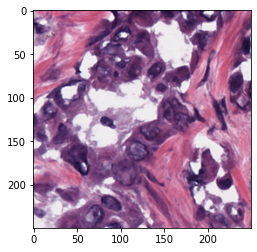

In [17]:
print("tumor")
plt.imshow(images[83])

In [18]:
def color_separate(ihc_rgb):
    ihc_hed = rgb2hed(ihc_rgb)
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1)))
    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))
    zdh = img_as_ubyte(np.dstack((null, d, h)))

    return (ihc_h, ihc_e, ihc_d, zdh)

In [19]:
segmented = []
for i in range(len(images)):
  H,E,D,HD = color_separate(images[i])
  device = cle.select_device()
  input_image = np.invert(H[:,:,2])
  #plt.imshow(input_image, cmap='gray')
  input_gpu = cle.push(input_image)
  sigma_spot_detection = 3
  sigma_outline = 1
  segmented_one = cle.voronoi_otsu_labeling(input_gpu, spot_sigma=sigma_spot_detection, 
                                      outline_sigma=sigma_outline)
  segmented.append(segmented_one)
  

  """
  statistics = cle.statistics_of_labelled_pixels(input_gpu, segmented) 

  table = pd.DataFrame(statistics)    

  print("number of nuclie segments: ", len(table))
  """


cl.OCLArray([[  0,   0,   0, ..., 134, 134, 134],
       [  0,   0,   0, ..., 134, 134, 134],
       [  0,   0,   0, ..., 134, 134, 134],
       ...,
       [  0,   0,   9, ...,   0,   0,   0],
       [  0,   0,   9, ...,   0,   0,   0],
       [  0,   0,   9, ...,   0,   0,   0]], dtype=uint32)
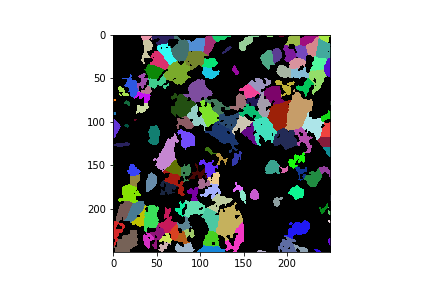

In [20]:
segmented[23]

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
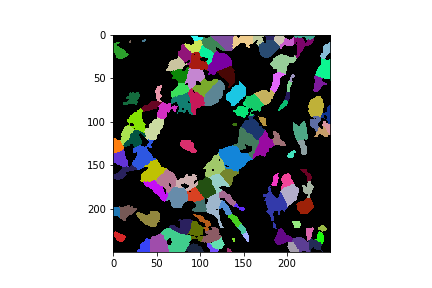

In [21]:
segmented[83]

In [22]:
def average_nuclei_density(segmented_image):
  nucleus_area = 0
  image_array = np.array(segmented_image)
  for i in range(data_width):
    for j in range(data_height):
      if segmented_image[i][j] > 0:
        nucleus_area = nucleus_area + 1;
  nucleus_density = round(nucleus_area/(data_width*data_height), 3)
  return nucleus_density

In [23]:
nuclei_dens_tumor = []
nuclei_dens_normal = []
for i in range(len(segmented)):
  avg_nuclei_dens = average_nuclei_density(segmented[i])
  if classes[i] == "normal":
    print("normal section of image nuclei density is ", avg_nuclei_dens)
    nuclei_dens_normal.append(avg_nuclei_dens)
  else:
    print("tumor section of image nuclei density is ", avg_nuclei_dens)
    nuclei_dens_tumor.append(avg_nuclei_dens)


normal section of image nuclei density is  0.363
normal section of image nuclei density is  0.097
normal section of image nuclei density is  0.266
normal section of image nuclei density is  0.19
normal section of image nuclei density is  0.075
normal section of image nuclei density is  0.122
normal section of image nuclei density is  0.222
normal section of image nuclei density is  0.044
normal section of image nuclei density is  0.222
normal section of image nuclei density is  0.38
normal section of image nuclei density is  0.578
normal section of image nuclei density is  0.523
normal section of image nuclei density is  0.338
normal section of image nuclei density is  0.461
normal section of image nuclei density is  0.447
normal section of image nuclei density is  0.483
normal section of image nuclei density is  0.312
normal section of image nuclei density is  0.168
normal section of image nuclei density is  0.055
normal section of image nuclei density is  0.079
normal section of imag

In [ ]:
print("normal")
print(statistics.mean(nuclei_dens_normal))
print(statistics.pstdev(nuclei_dens_normal))

print("tumor")
print(statistics.pstdev(nuclei_dens_tumor))
print(statistics.pstdev(nuclei_dens_tumor))

normal
0.338921568627451
0.15792649607410814
tumor
0.1510697418325297
0.1510697418325297
